<h1>Regression and Compressive Sensing (Solutions)</h1>

In [1]:
from equadratures import *
from equadratures.poly import vector_to_2D_grid
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator
from matplotlib import cm
np.random.seed(1) # So we can check the answers
plt.rcParams.update({'font.size': 14})

**Table of Contents**

[Example 1: Least squares regression of the Styblinski-Tang function](#eg1)

[Exercise 1: Regression on the "blade A" dataset](#ex1)

[Example 2: Compressive sensing with Styblinski-Tang function](#eg2)

[Exercise 2: Compressive sensing on the "Blade A" dataset](#ex2)

**Example 1: Least-squares regression of the Styblinski-Tang function<a name='eg1'></a>**

The 2D Styblinski-Tang function is defined as follows:
$$f(\mathbf{s}) = \frac{1}{2} \sum_{i=1}^2 s_i^4 - 16s_i^2 + 5s_i$$
where each variable $s_1,s_2$ is uniformly distributed between $[-1,1]$. We generate 50 samples from this function with random inputs, and add a little bit of noise in.

In [2]:
def StyblinskiTang(s):
    n = s.size
    f = 0
    for i in range(n):
        f += 0.5 * (s[i]**4 - 16.0*s[i]**2 + 5.0*s[i])
    return f

dims = 2
N = 50
S = np.random.uniform(-1,1,(N,dims))
y = np.squeeze(evaluate_model(S, StyblinskiTang)) + 0.001*np.random.randn(N)

Now, we define the parameters and basis for this problem. We will use a quartic (degree 4) polynomial in a tensor grid basis.

In [3]:
dims = 2
poly_order = 4
my_params = [Parameter(poly_order, distribution='uniform',lower=-1.0, upper=1.0)\
 for _ in range(dims)]
my_basis = Basis('tensor-grid')

Now, we can compute the coefficients by defining the polynomial model via a Poly object.

In [4]:
my_poly = Poly(my_params, my_basis, method='least-squares', sampling_args={'mesh':'user-defined',
                                                                          'sample-points':S,
                                                                          'sample-outputs':y})
my_poly.set_model()

How good was the fit? We can query the $R^2$ of the fit on some unseen validation data.

In [5]:
N_valid = 20
S_valid = np.random.uniform(-1,1,(N_valid,dims))
y_valid = np.squeeze(evaluate_model(S_valid, StyblinskiTang))
y_pred = np.squeeze(my_poly.get_polyfit(S_valid)) # Reshape into 1-D array

R2 = linregress(y_valid, y_pred)[2]
print(R2)

0.9999999312229404


We can visualize the coefficients as follows

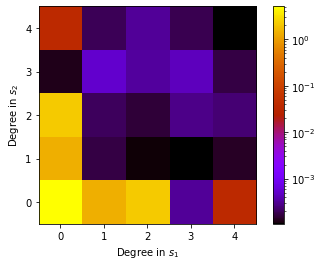

In [6]:
coeff_array = vector_to_2D_grid(my_poly.coefficients, my_basis.elements)[2]
plt.imshow(np.abs(coeff_array),origin='lower',cmap='gnuplot', norm=LogNorm())
plt.colorbar(ticks=LogLocator())
plt.xlabel('Degree in $s_1$')
plt.ylabel('Degree in $s_2$')
plt.show()

**Exercise 1: Regression on the "blade A" dataset**<a name='ex1'></a>

In this exercise, we study the relationship between the efficiency of a fan and the design of its blades. There are 25 design parameters that change the shape of the blade. They have been normalized such that each parameter is uniformly distributed between $[-1,1]$. We have 548 points in total, but we will reserve 48 points for testing how good our fit was. We will fit a quadratic surface with these parameters.

First, let's create a list of parameters and a basis that define our problem. For the basis, use a total order basis of maximum degree 2.

In [7]:
# Import data
X_train = np.loadtxt('data/bladeA_reg_training_inputs.dat') # 500 training points (you can use np.shape to check)
X_valid = np.loadtxt('data/bladeA_reg_validation_inputs.dat') # 48 validation points
y_train = np.loadtxt('data/bladeA_reg_training_outputs.dat')
y_valid = np.loadtxt('data/bladeA_reg_validation_outputs.dat')

In [8]:
# Define parameters (order 2)
dims = 25
poly_order = 2
my_params = [Parameter(poly_order,distribution='uniform',lower=-1.0, upper=1.0)\
 for _ in range(dims)]

# Define basis (total order)
my_basis = Basis('total-order')

Now, we can compute the coefficients via a polynomial model.

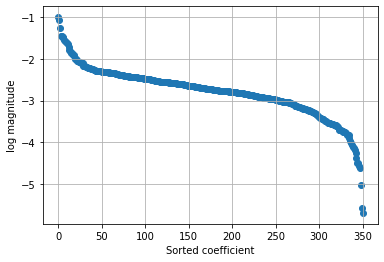

In [9]:
# Create an instance of the Poly class, choosing 'least-squares' as the method, and user-defined inputs/outputs.
# Use the training data, not the validation data.
my_poly = Poly(my_params, my_basis, method='least-squares',\
 sampling_args={'mesh':'user-defined', 'sample-points':X_train,\
  'sample-outputs':y_train})

# Compute its coefficients by set_model
my_poly.set_model()

# You can print the coefficients to see their values, or plot them with the following
plt.scatter(range(len(my_poly.coefficients)),np.sort(np.log10(np.abs(np.squeeze(my_poly.coefficients))))[::-1])
plt.xlabel('Sorted coefficient')
plt.ylabel('log magnitude')
plt.grid()
plt.show()

How good was the fit?

In [10]:
# Evaluate the fit on the validation data
# Use linregress to calculate the R^2 of the fit
# Hint: Use np.squeeze to convert a column vector to a 1-D array
R2 = linregress(np.squeeze(my_poly.get_polyfit(X_valid)), y_valid)[2]
print(R2)

0.9727765362088703


How many basis functions were used?

In [11]:
# Compute the cardinality of the basis
my_basis.cardinality

351

How many coefficients are larger than 0.001 in absolute value?

In [12]:
# Count the values in the coefficients array that are above 0.001 in absolute value
# Hint: use np.where and np.abs
len(np.where(np.abs(my_poly.coefficients) > 1e-3)[0])

254

**Example 2: Compressive sensing with Styblinski-Tang function**<a name='eg2'></a>

In Example 1, we saw that the coefficients of the Styblinski-Tang function were approximately sparse---there are many coefficients which are nearly zero. Hence, we repeat example 1, but now with compressive sensing, and see how many samples we can afford to save. To start off with, let's use 20. Note that this is smaller than the number of basis functions, so we need to use compressive sensing. (Alternatively, we could have reduced the number of basis functions via a total order basis)

In [13]:
def StyblinskiTang(s):
    n = s.size
    f = 0
    for i in range(n):
        f += 0.5 * (s[i]**4 - 16.0*s[i]**2 + 5.0*s[i])
    return f

dims = 2
N = 20
S = np.random.uniform(-1,1,(N,dims))
y = np.squeeze(evaluate_model(S, StyblinskiTang)) + 0.001*np.random.randn(N)

Again, we define the parameters and basis.

In [14]:
dims = 2
poly_order = 4
my_params = [Parameter(poly_order, distribution='uniform',lower=-1.0, upper=1.0)\
 for _ in range(dims)]
my_basis = Basis('tensor-grid')

Now, we compute the coefficients via compressive sensing.

In [15]:
my_poly = Poly(my_params, my_basis, method='compressive-sensing', sampling_args={'mesh':'user-defined',
               'sample-points':S,'sample-outputs':y})
my_poly.set_model()

We repeat the same exercise: Examine the goodness of fit with validation data, and then plot the coefficients.

In [16]:
N_valid = 20
S_valid = np.random.uniform(-1,1,(N_valid,dims))
y_valid = np.squeeze(evaluate_model(S_valid, StyblinskiTang))
y_pred = np.squeeze(my_poly.get_polyfit(S_valid)) # Reshape into 1-D array

R2 = linregress(y_valid, y_pred)[2]
print(R2)

0.9999988250259315


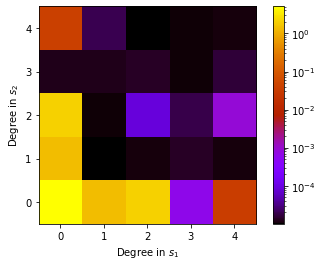

In [17]:
coeff_array = vector_to_2D_grid(my_poly.coefficients, my_basis.elements)[2]
# Add a small quantity to ease visualization
plt.imshow(np.abs(coeff_array)+1e-5,origin='lower',cmap='gnuplot', norm=LogNorm()) 
plt.colorbar(ticks=LogLocator())
plt.xlabel('Degree in $s_1$')
plt.ylabel('Degree in $s_2$')
plt.show()

Note that compressive sensing tends to be less reliable. If you get a poor $R^2$, a simple remedy would be to try again with different random samples. However, if the settings are appropriate, compressive sensing can bypass the restrictions of least squares to get the same results with fewer data. 

**Exercise 2: Compressive sensing on the "Blade A" dataset**<a name='ex2'></a>

Again, in exercise 1 we saw that only a portion of the coeffients in the approximation model for the fan efficiency are significantly large. We may be able then to reduce the number of data points we need to produce the same model. 

As before, we define the parameters and basis. This time, we will use 300 points and assign the rest as validation data. 

In [18]:
# Import data
X_train = np.loadtxt('data/bladeA_cs_training_inputs.dat') # 300 training points (you can use np.shape to check)
X_valid = np.loadtxt('data/bladeA_cs_validation_inputs.dat') # 248 validation points
y_train = np.loadtxt('data/bladeA_cs_training_outputs.dat')
y_valid = np.loadtxt('data/bladeA_cs_validation_outputs.dat')

In [19]:
# Define parameters (order 2)
dims = 25
poly_order = 2
my_params = [Parameter(poly_order,distribution='uniform',lower=-1.0, upper=1.0)\
 for _ in range(dims)]

# Define basis (total order)
my_basis = Basis('total-order')

Now, we can compute the coefficients via a polynomial model.

The noise level used is 0.01.


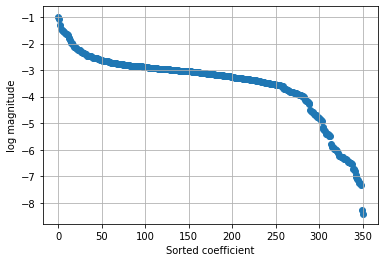

In [20]:
# Create an instance of the Poly class, choosing 'compressive-sensing' as the method, 
# and user-defined inputs/outputs.
# Use the training data, not the validation data.
# Set 'verbose' to True in solver_args to query the noise level used!
my_poly = Poly(my_params, my_basis, method='compressive-sensing',\
 sampling_args={'mesh':'user-defined', 'sample-points':X_train,\
'sample-outputs':y_train}, solver_args={'verbose':True})

# Compute its coefficients by set_model
my_poly.set_model()

# You can print the coefficients to see their values, or plot them with the following
plt.scatter(range(len(my_poly.coefficients)),np.sort(np.log10(np.abs(np.squeeze(my_poly.coefficients))))[::-1])
plt.xlabel('Sorted coefficient')
plt.ylabel('log magnitude')
plt.grid()
plt.show()

How good was the fit?

In [21]:
# Evaluate the fit on the validation data
# Use linregress to calculate the R^2 of the fit
R2 = linregress(np.squeeze(my_poly.get_polyfit(X_valid)), y_valid)[2]
print(R2)

0.9814787100364579


What was the noise level ($\eta$) used? Compare it with the standard deviation of the training output.

In [22]:
# Compute the standard deviation of the output.
np.std(y_train)

0.17702932163908577

You should notice that the noise level is 0.01, which is small, but not completely negligible, compared to the standard deviation of the output. This acknowledges the fact that we have a bit of fitting error (the data is not exactly a quadratic), but the fitting error does not completely swamp the variation of the regression function.